In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

plt.rcParams['figure.figsize'] = (6, 6)
plot_dir = './plots/'

In [28]:
tc = test_case.TestCaseB()
sim_args = tc.time_frame, tc.start_location, tc.start_velocity

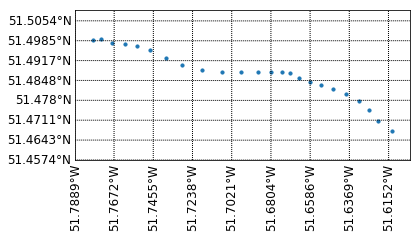

In [30]:
tc.plot_track(sizes=10)

In [5]:
sim = simulator.Simulator(*sim_args)
sim.add_result(tc.ref_times, tc.ref_lats.values, tc.ref_lons.values, 'reference')

In [6]:
xds = sim.run_simulation(store_results_as='default')

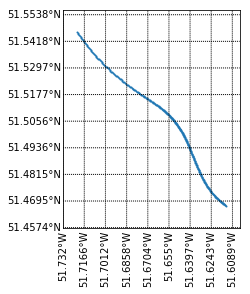

In [7]:
fig, ax = sim.plot_track(['default'])

# Optimizing Ca and Cw

### Scipy minimize

In [8]:
keys = ['Ca', 'Cw']
x0 = [1, 1]
bounds = [[0.01, 15], [0.01, 15]]
reference_vectors = [tc.ref_lats, tc.ref_lons]

optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

optimization_result

      fun: 0.023994024372663115
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00206806, -0.00267813])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 111
      nit: 8
   status: 0
  success: True
        x: array([2.00878111, 0.43114705])

In [9]:
Ca, Cw = optimization_result.x
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
xds = sim.run_simulation(store_results_as='optimized', **run_sim_kwargs)

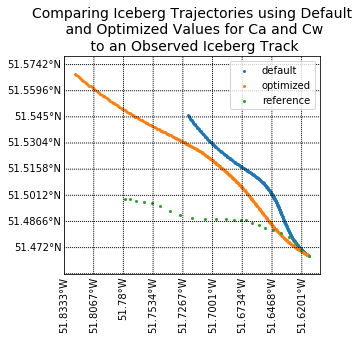

In [18]:
title = 'Comparing Iceberg Trajectories using Default\n and Optimized Values for Ca and Cw\n to an Observed Iceberg Track'
sizes = [4] * 3
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'sizes': sizes, 'legend_kwargs': legend_kwargs}
fig, ax = sim.plot_track(['default', 'optimized', 'reference'], labels=['default', 'optimized', 'reference'], 
                         **kwargs)
fig.savefig(plot_dir + 'tracks_from_default_and_optimized_Ca_and_Cw.png', bbox_inches='tight')

### Brute force

In [19]:
Ca_num = 16
Cw_num = 16
Ca_lower_bound = 0.1; Ca_upper_bound = 15
Cw_lower_bound = 0.1; Cw_upper_bound = 15

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':

    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

mse_matrix = np.zeros((Ca_num, Cw_num))
keys = ['Ca', 'Cw']
reference_vectors = [tc.ref_lats, tc.ref_lons]

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

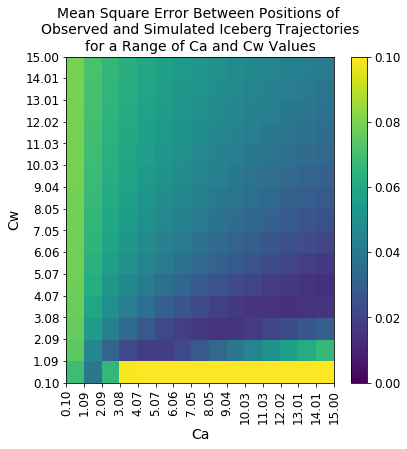

In [26]:
fig = plt.figure(figsize=(6,6))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0, vmax=0.1)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.title('Mean Square Error Between Positions of \n'+ \
          'Observed and Simulated Iceberg Trajectories\n' + \
          'for a Range of Ca and Cw Values')

plt.colorbar()

plt.show()

fig.savefig(plot_dir + 'mse_color_plot.png', bbox_inches='tight')